# Julia Quickstart

**John Stachurski** October 2023

This is a super quick introduction to Julia for people who already have programming experience in MATLAB, Python, etc.  It requires the following packages:

In [12]:
using PyPlot, Random, Distributions, BenchmarkTools

## Syntax 

### Example 1

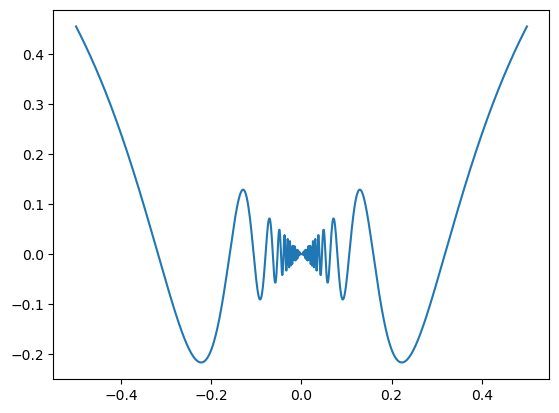

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f05a39789d0>

In [111]:
f(x) = x * sin(1/x)
x_grid = LinRange(-.5, .5, 1_000)
y_grid = f.(x_grid)  # pointwise map

fig, ax = plt.subplots()
ax.plot(x_grid, y_grid)


### Example 2

In [105]:
"""
Generate a draw from the Binomial(n, p) distribution, which counts
the number of successes, with probability p, in n independent trials.

"""
function binomial_draw(n, p)
    counter = 0
    for i in 1:n
        U = rand()        # uniform(0,1) draw
        if U < p          # with probability p
            counter += 1
        end
    end
    return counter
end

binomial_draw

Let's generate some draws and plot a histogram.

In [24]:
n, p = 40, 0.6
seed = 1234
num_draws = 10_000_000

Random.seed!(seed)
draws = [binomial_draw(n, p) for i in 1:num_draws];
draws[1:5]

5-element Vector{Int64}:
 23
 24
 26
 19
 21

In [25]:
mean(draws) - n * p # should be close to zero

-5.699999999109195e-6

In [26]:
var(draws) - n * p * (1 - p) # should be close to zero

-0.0005595400884459423

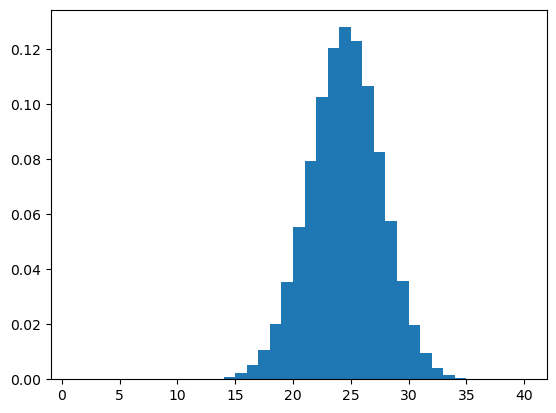

In [27]:
fig, ax = plt.subplots()
ax.hist(draws, bins=1:n, density=true);

Incidentally, binomial draws can be generated more easily using `Distributions`

In [28]:
b = Binomial(n, p)
draws = rand(b, num_draws);

## Variables and types

### floats, ints, etc

In [34]:
x = 1.0
typeof(x)

Float64

In [35]:
typeof(x) <: Number

true

In [36]:
typeof(x) <: String

false

In [37]:
using Base: show_supertypes
show_supertypes(typeof(x))

Float64 <: AbstractFloat <: Real <: Number <: Any

In [38]:
y = 2
typeof(y)

Int64

In [40]:
show_supertypes(typeof(y))

Int64 <: Signed <: Integer <: Real <: Number <: Any

In [41]:
y = convert(Int32, y)

2

In [42]:
typeof(y)

Int32

In [43]:
z = "foobar"

"foobar"

In [44]:
show_supertypes(typeof(z))

String <: AbstractString <: Any

Automatic type promotion

In [47]:
z = x + y   # Int + Float

3.0

In [48]:
typeof(z)

Float64

### Container types

#### Tuples

In [49]:
vars = 10, 1.0, "foobar"   # vars = a, b, c  or  vars = (a, b, c)

(10, 1.0, "foobar")

In [50]:
typeof(vars)

Tuple{Int64, Float64, String}

In [51]:
a, b, c = vars;  # tuple unpacking

In [52]:
a

10

In [53]:
vars[1] = "foo"  # tuples are immutable

LoadError: MethodError: no method matching setindex!(::Tuple{Int64, Float64, String}, ::String, ::Int64)

#### Arrays

In [57]:
vars = ["foo", 1.0, "foobar"]

3-element Vector{Any}:
  "foo"
 1.0
  "foobar"

In [58]:
vars[1] = "jstac"

"jstac"

In [59]:
vars

3-element Vector{Any}:
  "jstac"
 1.0
  "foobar"

In [60]:
z = zeros(3)

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [61]:
z = zeros(Int32, 3)

3-element Vector{Int32}:
 0
 0
 0

In [62]:
z = Array{Float64}(undef, 3)   # "empty" array

3-element Vector{Float64}:
 6.90028388282155e-310
 6.9003406232444e-310
 0.0

#### NamedTuples

In [63]:
z = (; a=10, b=2.0, c="foobar")  # building a NamedTuple

(a = 10, b = 2.0, c = "foobar")

In [64]:
typeof(z)

NamedTuple{(:a, :b, :c), Tuple{Int64, Float64, String}}

In [65]:
z.a

10

In [66]:
z.b

2.0

In [67]:
z.b = 12

LoadError: setfield!: immutable struct of type NamedTuple cannot be changed

In [68]:
(; c, b) = z   # unpacking by name

(a = 10, b = 2.0, c = "foobar")

In [69]:
b

2.0

In [70]:
c

"foobar"

#### Concrete vs abstract arrays

In [81]:
array_1 = [i * 0.001 for i in 0:1000];

In [82]:
minimum(array_1), maximum(array_1)

(0.0, 1.0)

In [83]:
show_supertypes(typeof(array_1))

Vector{Float64} <: DenseVector{Float64} <: AbstractVector{Float64} <: Any

In [84]:
array_2 = LinRange(0, 1, 1001)   # memory efficient linear grid

1001-element LinRange{Float64, Int64}:
 0.0, 0.001, 0.002, 0.003, 0.004, 0.005, …, 0.996, 0.997, 0.998, 0.999, 1.0

In [85]:
show_supertypes(typeof(array_2))

LinRange{Float64, Int64} <: AbstractRange{Float64} <: AbstractVector{Float64} <: Any

In [86]:
isapprox(array_1, array_2)

true

In [87]:
varinfo(r"array_1")

| name    |      size | summary                      |
|:------- | ---------:|:---------------------------- |
| array_1 | 7.859 KiB | 1001-element Vector{Float64} |


In [88]:
varinfo(r"array_2")

| name    |     size | summary                               |
|:------- | --------:|:------------------------------------- |
| array_2 | 32 bytes | 1001-element LinRange{Float64, Int64} |


## Names and data

In the code

In [89]:
a = randn(3)

3-element Vector{Float64}:
 -0.00688421178617798
  1.9487798744166431
  2.0414786361006882

the name `a` is bound to the `Vector{Float64}` object created in memory

If we now write

In [90]:
b = a;

then the name `b` is bound to the same object --- the data is **not** copied.

In [91]:
b

3-element Vector{Float64}:
 -0.00688421178617798
  1.9487798744166431
  2.0414786361006882

In [92]:
pointer(b)

Ptr{Float64} @0x00007f05e5c05a30

In [93]:
pointer(a)

Ptr{Float64} @0x00007f05e5c05a30

This means that mutating `b` also mutates `a`

In [94]:
b[1] = 42.0

42.0

In [95]:
b

3-element Vector{Float64}:
 42.0
  1.9487798744166431
  2.0414786361006882

In [96]:
a

3-element Vector{Float64}:
 42.0
  1.9487798744166431
  2.0414786361006882

If you want a separate copy of an array, use `copy`

In [97]:
c = copy(a);

In [98]:
c

3-element Vector{Float64}:
 42.0
  1.9487798744166431
  2.0414786361006882

In [99]:
pointer(c)

Ptr{Float64} @0x00007f05e4fe0360

In [100]:
pointer(a)

Ptr{Float64} @0x00007f05e5c05a30

Since `c` and `a` are bound to different data, I can mutate one without changing the other.

In [103]:
c[:] .= 10.0 ;    

In [104]:
c

3-element Vector{Float64}:
 10.0
 10.0
 10.0

In [120]:
a

3-element Vector{Float64}:
 42.0
  0.19053790524247688
  0.9536631820508188

## Flow Control

### Basics

In [47]:
vals = randn(3)

3-element Vector{Float64}:
 -1.3540149524182823
  0.17526568177347415
 -0.8508677530144726

In [48]:
for (i, v) in enumerate(vals)
    if v < 0
        v = -v
    end
    println("absolute value of element $i is $v")
end

absolute value of element 1 is 1.3540149524182823
absolute value of element 2 is 0.17526568177347415
absolute value of element 3 is 0.8508677530144726


In [49]:
vals

3-element Vector{Float64}:
 -1.3540149524182823
  0.17526568177347415
 -0.8508677530144726

### Functions

#### Basic syntax

In [121]:
"""
This is the docstring of the function.

The function has 

    one positional arg a
    one positional arg with default value b
    two keyword args with defaults c, d
"""
function f(a, b=10; c=20, d=30) 
    return a + b + c + b
end

f

In [51]:
f(10)

50

In [124]:
f(10, b=100)  # wrong because b is not a keyword argument

LoadError: MethodError: no method matching f(::Int64, ::Int64; b::Int64)

[0mClosest candidates are:
[0m  f(::Any, ::Any; c, d)[91m got unsupported keyword argument "b"[39m
[0m[90m   @[39m [35mMain[39m [90m[4mIn[121]:9[24m[39m
[0m  f(::Any)[91m got unsupported keyword argument "b"[39m
[0m[90m   @[39m [35mMain[39m [90m[4mIn[121]:9[24m[39m


In [125]:
f(10, 100)   # calls with a=10 and b=100

230

In [127]:
f(10, d=100)  # OK because d is a keyword argument

50

#### A more complex example

The next example illustrates

* passing a function to a function
* multiple dispatch

In [54]:
function successive_approximation(f, x0::Real; max_iter=100_000, tol=1e-6)
    println("Applying successive approximation starting at scalar $x0")
    error = Inf
    i = 0
    x = x0
    while error > tol && i < max_iter
        x_new = f(x)
        error = abs.(x_new - x)
        x = x_new
        i += 1
    end
    return x
end

successive_approximation (generic function with 1 method)

In [55]:
function successive_approximation(f, x0::Vector; max_iter=100_000, tol=1e-6)
    println("Applying successive approximation starting at vector $x0")
    error = Inf
    i = 0
    x = x0
    while error > tol && i < max_iter
        x_new = f(x)
        error = maximum(abs.(x_new - x))   # added maximum 
        x = x_new
        i += 1
    end
    return x
end

successive_approximation (generic function with 2 methods)

In [56]:
f(x) = 0.5x
successive_approximation(f, 100)

Applying successive approximation starting at scalar 100


7.450580596923828e-7

In [57]:
A = rand(2, 2) * 0.5

2×2 Matrix{Float64}:
 0.286002  0.140703
 0.119347  0.195809

In [58]:
f(x) = A * x

f (generic function with 2 methods)

In [59]:
successive_approximation(f, ones(2))

Applying successive approximation starting at vector [1.0, 1.0]


2-element Vector{Float64}:
 5.434370358181803e-7
 3.557625356268153e-7

### Local scope

#### Local scope in functions

In [60]:
x = 10
function test()
    x = "foobar"
    print(x)
end

test (generic function with 1 method)

In [61]:
test()

foobar

In [62]:
x  # global x is not affected

10

#### Local scope in loops

In [63]:
vals = randn(3)

3-element Vector{Float64}:
 -0.34748126086167846
 -1.5939316550279452
 -0.6924705860979021

Compare

In [64]:
s = 0.0
a = "foo"
for v in vals
    a = abs(v)  # overwrites global a
    s += a
end

In [65]:
a

0.6924705860979021

and

In [66]:
s = 0.0
a = "foo"
for v in vals
    local a = abs(v)  # preserves global a
    s += a
end

In [67]:
a

"foo"

If a global variable does not exist, local variables are destroyed after the loop terminates.

In [68]:
s = 0.0
for v in vals
    new_var = abs(v)  # overwrites global a
    s += new_var
end

In [69]:
new_var

LoadError: UndefVarError: `new_var` not defined

## Performance tips

* all time-critical code should be written in functions
* avoid globals or declare them as const
* preserve type stability of functions

### Minimize globals

Here's a pure function

In [70]:
function f(x, a=1.0)
    y = x + a
    return y
end

f (generic function with 2 methods)

In [71]:
@code_warntype(f(1.0))

MethodInstance for f(::Float64)
  from f(x) @ Main In[70]:1
Arguments
  #self#::Core.Const(f)
  x::Float64
Body::Float64
1 ─ %1 = (#self#)(x, 1.0)::Float64
└──      return %1



In [72]:
@code_llvm(f(1.0))

;  @ In[70]:1 within `f`
define double @julia_f_4591(double %0) #0 {
top:
;  @ In[70]:2 within `f` @ In[70]:2
; ┌ @ float.jl:408 within `+`
   %1 = fadd double %0, 1.000000e+00
; └
;  @ In[70]:2 within `f`
  ret double %1
}


Here's an alternative version that relies on a global variable.

In [73]:
a = 1.0
function g(x)
    y = x + a
    return y
end

g (generic function with 1 method)

In [74]:
@code_warntype(g(1.0))

MethodInstance for g(::Float64)
  from g(x) @ Main In[73]:2
Arguments
  #self#::Core.Const(g)
  x::Float64
Locals
  y::Any
Body::Any
1 ─     (y = x + Main.a)
└──     return y



In [75]:
@code_llvm(g(1.0))

;  @ In[73]:2 within `g`
define nonnull {}* @julia_g_4644(double %0) #0 {
top:
  %1 = alloca [2 x {}*], align 8
  %gcframe4 = alloca [4 x {}*], align 16
  %gcframe4.sub = getelementptr inbounds [4 x {}*], [4 x {}*]* %gcframe4, i64 0, i64 0
  %.sub = getelementptr inbounds [2 x {}*], [2 x {}*]* %1, i64 0, i64 0
  %2 = bitcast [4 x {}*]* %gcframe4 to i8*
  call void @llvm.memset.p0i8.i32(i8* noundef nonnull align 16 dereferenceable(32) %2, i8 0, i32 32, i1 false)
  %thread_ptr = call i8* asm "movq %fs:0, $0", "=r"() #5
  %ppgcstack_i8 = getelementptr i8, i8* %thread_ptr, i64 -8
  %ppgcstack = bitcast i8* %ppgcstack_i8 to {}****
  %pgcstack = load {}***, {}**** %ppgcstack, align 8
;  @ In[73]:3 within `g`
  %3 = bitcast [4 x {}*]* %gcframe4 to i64*
  store i64 8, i64* %3, align 16
  %4 = getelementptr inbounds [4 x {}*], [4 x {}*]* %gcframe4, i64 0, i64 1
  %5 = bitcast {}** %4 to {}***
  %6 = load {}**, {}*** %pgcstack, align 8
  store {}** %6, {}*** %5, align 8
  %7 = bitcast {}*** %pgc

### Avoid type instability

A function is type stable if the return type depends on its inputs only through their type, not their values.

In [76]:
function f(x)
    y = x ≤ 0 ? zero(x) : x
    return y
end 

f (generic function with 2 methods)

If I know the input type, then I know the output type.

In [77]:
f(1.0)

1.0

In [78]:
f(1)

1

In [79]:
@code_warntype(f(1.0))

MethodInstance for f(::Float64)
  from f(x) @ Main In[76]:1
Arguments
  #self#::Core.Const(f)
  x::Float64
Locals
  y::Float64
  @_4::Float64
Body::Float64
1 ─      Core.NewvarNode(:(y))
│   %2 = (x ≤ 0)::Bool
└──      goto #3 if not %2
2 ─      (@_4 = Main.zero(x))
└──      goto #4
3 ─      (@_4 = x)
4 ┄      (y = @_4)
└──      return y



Now let's write a function that uses `f`

In [80]:
function test(f, n=1_000_000)
    s = 0.0
    for i in 1:n
        x = randn()
        y = f(x)
        s += y
    end
    return s
end

test (generic function with 3 methods)

In [81]:
test(f)

398992.4554904771

In [82]:
using BenchmarkTools

In [83]:
@btime test(f)

  2.052 ms (0 allocations: 0 bytes)


398852.6612787183

The following function is not type stable.

In [84]:
function bad_f(x)
    if x ≤ 0
        out = 0
    else
        out = x
    end
    return out
end

bad_f (generic function with 1 method)

In [85]:
bad_f(-1.0)

0

In [86]:
bad_f(1.0)

1.0

In [87]:
@code_warntype(bad_f(1.0))

MethodInstance for bad_f(::Float64)
  from bad_f(x) @ Main In[84]:1
Arguments
  #self#::Core.Const(bad_f)
  x::Float64
Locals
  out::Union{Float64, Int64}
Body::Union{Float64, Int64}
1 ─      Core.NewvarNode(:(out))
│   %2 = (x ≤ 0)::Bool
└──      goto #3 if not %2
2 ─      (out = 0)
└──      goto #4
3 ─      (out = x)
4 ┄      return out



In [88]:
@btime test(bad_f)

  2.677 ms (0 allocations: 0 bytes)


398117.3003939513